In [ ]:
# default_exp diffusion_flow_embedding
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

In [ ]:
# export
# hide
import torch
import numpy as np
import matplotlib.pyplot as plt

# A collection of Loss functions for Flow Embedder

## Compute Affinity matrix

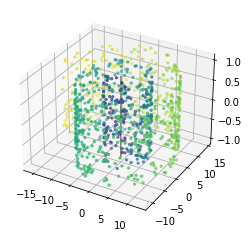

In [ ]:
from directed_graphs.datasets import directed_swiss_roll_uniform, plot_directed_3d
X, flow, labels = directed_swiss_roll_uniform(num_nodes=1000, num_spirals=2.5, radius=1, height=2, xtilt=0, ytilt=0)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

In [ ]:
X = torch.tensor(X)
flow = torch.tensor(flow)

### Anisotropic Symmetric Affinity

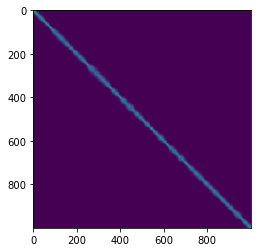

In [ ]:
from directed_graphs.diffusion_flow_embedding import anisotropic_kernel
D = torch.cdist(X, X)
W = anisotropic_kernel(D, sigma=1, alpha=0.25)
plt.imshow(W)

### Flow Assymetrical Affinity

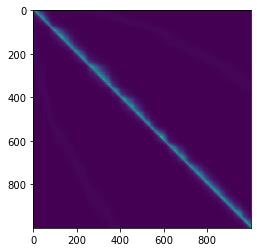

In [ ]:
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset
W = affinity_matrix_from_pointset_to_pointset(X, X, flow, sigma=2, flow_strength=2)
plt.imshow(W)

## Loss functions

In [ ]:
X = torch.rand(5, 10) # 5 points in 10 dimensions
ground_truth_flows = torch.rand(5, 10) # 5 vectors in 10 dimensions
embedded_points = torch.rand(5, 2) # 5 points in 2 dimensions
embedded_flows = torch.rand(5, 2) # 5 vectors in 2 dimensions

In [ ]:
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset
P_graph = affinity_matrix_from_pointset_to_pointset(X, X, ground_truth_flows)
P_embedding = affinity_matrix_from_pointset_to_pointset(embedded_points, embedded_points, embedded_flows)

## KL Divergence

In [ ]:
# export
def kl_divergence_loss(KLD, P_graph, P_embedding):
  P_embedding = torch.log(P_embedding)
  if KLD.log_target:
    P_graph = torch.log(P_graph)
  if P_embedding.is_sparse:
    P_embedding = P_embedding.to_dense()
    P_graph = P_graph.to_dense()
  loss = KLD(P_embedding, P_graph)
  return loss

In [ ]:
KLD = torch.nn.KLDivLoss(reduction='batchmean', log_target=False)
print(f"KL(P_graph     || P_embedding) = {kl_divergence_loss(KLD, P_graph, P_embedding)}")
print(f"KL(P_embedding || P_graph    ) = {kl_divergence_loss(KLD, P_embedding, P_graph)}")

KL(P_graph     || P_embedding) = -0.11314375698566437
KL(P_embedding || P_graph    ) = 2.795036554336548


## Symmetric KL Divergence

In [ ]:
# export
def kld_symmetric_loss(KLD, P_graph, P_embedding):
  loss = (kl_divergence_loss(KLD, P_graph, P_embedding) + kl_divergence_loss(KLD, P_embedding, P_graph)) / 2
  return loss

In [ ]:
print(f"Symmetric KL(P_graph, P_embedding) = {kld_symmetric_loss(KLD, P_graph, P_embedding)}")

Symmetric KL(P_graph, P_embedding) = 1.3409464359283447


## Diffusion Map MSE

In [ ]:
# export
def diffusion_map_loss(P_graph, embedded_points):
  D_graph = torch.cdist(P_graph, P_graph)
  D_embedding = torch.cdist(embedded_points, embedded_points)
  loss = torch.norm(D_graph - D_embedding)**2
  return loss

In [ ]:
print(f"DM(P_graph, embedded_points) = {diffusion_map_loss(P_graph, embedded_points)}")

DM(P_graph, embedded_points) = 3.1371378898620605


## Flow Cosine MSE

In [ ]:
# export
def flow_cosine_loss(X, ground_truth_flows, embedded_flows):
  cosine_graph = ground_truth_flows @ ground_truth_flows.T
  cosine_embedding = embedded_flows @ embedded_flows.T
  W = torch.exp(-torch.cdist(X, X))
  loss = torch.sum((cosine_graph - cosine_embedding) * W)
  return loss

In [ ]:
print(f"Flow Similarity(X, flows, embedded_flows) = {flow_cosine_loss(X, ground_truth_flows, embedded_flows)}")

Flow Similarity(X, flows, embedded_flows) = 23.870094299316406
